# Basics of Mobile Robotics: Project Report

**Authors:**
Louis Gevers (351613), 
Paul Blossier (353190), 
Zing Shawn Tan (360877), 
Naël Dillenbourg (288423)

**Course:**  MICRO-452 

---

# 0. Short Introduction

Our robotic project was imagined as a rover, trying to reach water on a planet. Two types of obstacles may be found on our path, rocks that have been mapped beforehand and craters that are more recent and not on the map but that need to be avoided.

__Disclaimer: if the images do not load, please launch the notebook from the root folder__

## 1. Robot Environment

The robot has to navigate a square environment on a white sheet, where it has to reach a blue square while avoiding the red ones, from wherever it is released.
We make use of ArUco markers, whose detection is robust, fast, and simple [1].
Four markers are used to denote the corners of the environment, and a fifth one is put on the robot to obtain the relative position and orientation of the robot with respect to the corners.
We first used small colored squares, but as we will show in the vision section, we have to choose the correct values to detect these colours, which can change with different lighting conditions.
We therefore chose to only calibrate for the goal and obstacles, blue and red squares respectively, and not the corners and robot position, which use ArUco markers and therefore do not need adjustements with different lighting.

The environment for this project has two types of obstacles:
1. Permanent obstacles which are accounted for in the path planning and detected by our vision module (the red squares).
2. Temporary obstacles which we cannot account for during path planning. These are detected by the local navigation module that takes control when an object is close enough to the proximity sensors.

We chose a sparse, non-discrete environment, as we were more comfortable for the Thymio to do long straight lines with occasional small turns rather than the many rotations with small advancements required in a grid-like environment (it would also be faster).
As we went on with the project we discovered that this brings its challenges, as it is much harder to update the map when seeing obstacles and the control is not as straightforward.
If we were to do the project again we would probably go for a grid-like structure for easier map updates.

Figure 1 summarizes the robot environment:
- A robot has an $x$ and $y$ coordinate starting from the top left corner
- A robot has an angle $\alpha$ from the y-axis
- The robot has an ArUco marker
- Each corner of the terrain has an ArUco marker
- The goal position corresponds to a blue paper on the terrain
- Red areas should be avoided
- Unknown obstacles might appear

![environment](../img/terrain_representation.svg)
<center> Figure 1: Visual representation of robot terrain </center>

## 2. Project Structure

### 2.1 Project dependencies

Using best development practices, we have our python dependencies in a `requirements.txt` file.
Furthermore, we have all of our Python source code in different files under the `src` folder.
To use them in the notebook we install them with `pip` as well, with the `-e` flag to capture potential edits.
(We use the `import sys` method to make sure pip installs it in the currently used Jupyter kernel)

In [1]:
%%capture
# This cell can be pretty noisy, so we hide the output. If you want to see it remove the %%capture magic keyword
import sys
# Install dependencies
!{sys.executable} -m pip install -r "../requirements.txt"
# Install the project source files (i.e. the src directory specified in the root-level setup.py)
!{sys.executable} -m pip install -e "../"

# Imports for the notebook
import numpy as np
import time

### 2.2 Project models

To make integration as easy as possible while allowing us to work on the different parts independently, we started the project by agreeing on common datastructures to represent sensor data, robot pose, obstacles, etc..
All these models can be found in the `src/model.py` file as a separate class.
Using these models we can define what each component of the project has to implement and what it needs.
For example, the path planning component needs a representation of the obstacles, the goal, and the intial position of the robot, and returns a path.

The cell below shows how to create each model:

In [2]:
# Import the script
from src import model

### Modeling the world of the robot
# A simple 2D point, can be used for a position or in sequence for a path
point = model.Point(x=0, y=0)
# Representation of a robot, both position as a point and angle in radians
robot = model.Robot(position=point, angle=0)
# Representation of an obstacle, which contains an arbitrary number of points
obstacle = model.Obstacle(corners=[model.Point(x=0,y=0), model.Point(x=1, y=0), model.Point(x=5,y=10)])
# Representation of the world state, which contains a robot, a goal, and a list of obstacles
world = model.World(robot=robot, goal=point, obstacles=[obstacle])

### Modeling the data from the robot
# Speed of the robot wheels
speed = model.MotorSpeed(left=100, right=100)
# Horizontal IR sensor values
horizontal = model.HorizontalSensor([0, 0, 0, 0, 0]) # Initialized with a list, representation from the thymio
horizontal.center # Can access individual values with names properties
# Ground IR sensor values
ground = model.GroundSensor([0, 0])
ground.left
# Model containing all the relevant sensor values from the Thymio
sensor_data = model.SensorReading(horizontal=horizontal, ground=ground, motor=speed)

### 2.3 Thymio abstraction

We made our own Thymio class to send motor commands and obtain sensor values from the Thymio without worrying about the exact `tdmclient` implementation.
This abstraction allowed us to focus on our algorithms using the predefined models, without having to worry about the exact Thymio implementation. All one has to do is use an instance of the `Thymio` class inside the `src/thymio.py` file.

The cell below will connect and disconnect with the Thymio. Note that the Thymio's LEDs are turned off when connected to avoid disturbing vision.

In [3]:
from src import thymio

try:
    th = thymio.Thymio()
    print("Connected to Thymio")
    # Example usage:
    th.process_command(command=model.MotorSpeed(left=0, right=0))
    sensor_data = th.read_sensor_data()
    # Disconnect
    th.stop()
except:
    print("Unable to connect to the Thymio! Is it connected? Is Thymio suite open?")

Connection to Thymio failed!
Unable to connect to the Thymio! Is it connected? Is Thymio suite open?


## 3. Implementation

### 3.1 Vision


In [4]:
# Vision alorithms are in src/vision.py
from src import vision
# Some drawing helper functions are in src/draw.py
from src import draw

### 3.1.1 Image sources

The vision pipeline acts on images.
The typically come from the webcam, but can also come from images or precorded video to make development easier.
We therefore separate the image source from the full pipeline.
Here, to illustrate the vision algorithms, we use a preloaded image source:

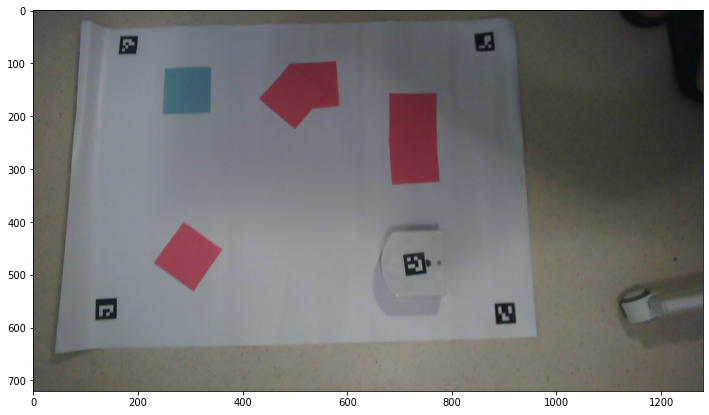

In [5]:
source = vision.ImageSource('../data/test-img1.jpg')
# No matter the source (image, video, webcam) we can get a frame by calling the get_frame() method:
frame = source.get_frame()
draw.plot_image(frame)

<center> Figure 2 : Example of an image captured by the webcam </center>
<center> <i> x and y are in pixel </i> </center>

### 3.1.2 Transform image with ArUco corners

As seen in the image above, there is one aruco marker in each corner.
Each ArUco marker has a unique ID, if we put them in a specific order we will know which marker belongs to which corner.
The cell below displays the detected markers with their IDs using OpenCVs `cv2.aruco.detectMarkers()` [1].
We can use markers 0 to 3 as corners.

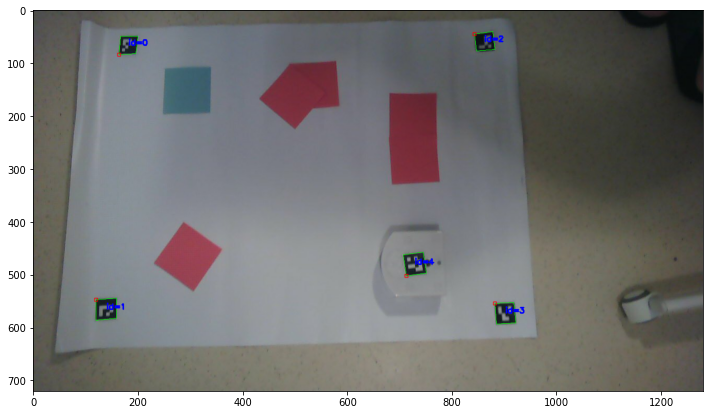

In [6]:
# Our VisionTools class contains various methods using OpenCV, such as detecting ArUco markers.
tools = vision.VisionTools()
draw.display_aruco_markers(source, tools)

<center> Figure 3 : ArUco markers detection on the previous image</center>
<center> <i> x and y are in pixel </i> </center>

Using the four coordinates of the ArUco markers, we can use OpenCV's `getPerspectiveTransform()` with `warpPerspective()` [2] to warp the image such that the terrain covers it entirely.
This will map each pixel from the original image to the new image with markers in the corners.
Since we are essentially making the image larger, it will interpolate mixing pixels as well.

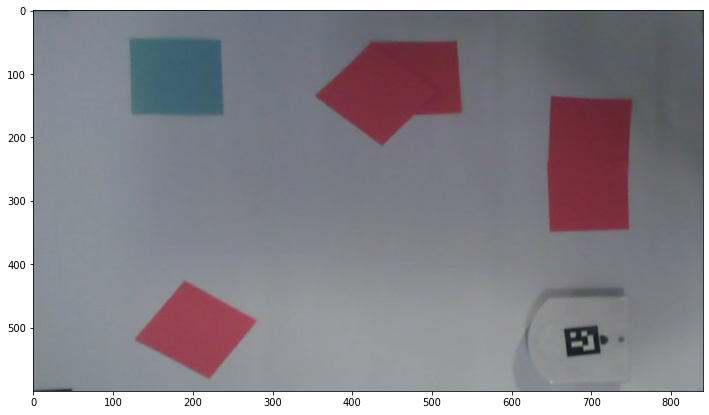

In [7]:
frame = source.get_frame()
# A Map mapping an ArUco marker ID to its position in the image
corners_by_id = tools.get_aruco_dict(frame)
# The new calibrated image
calibrated = tools.get_aruco_calibrated(frame, corners_by_id)
draw.plot_image(calibrated)

<center> Figure 4 : Cropping the image to the terrain area</center>
<center> <i> x and y are in pixel </i> </center>

This "calibrated" image allows us to work in a coordinate system relative to the 4 ArUco markers.
It also removes the background of the floor and only displays the white sheet, allowing us to make stronger assumptions (such as no other colors present) for the detection of obstacles and goal.

### 3.1.3 Robot pose estimation

We use the remaining ArUco marker on the calibrated image to determine the robot position.
Since ArUco markers have unique orientation, we can also use this for the robot's orientation.
OpenCV's implementation of ArUco marker detection gives us the corners in clockwise order starting from the top left one.
If we align the ArUco top left corner with the top left corner of the Thymio, we can compute the angle between the Thymio and the y-axis.

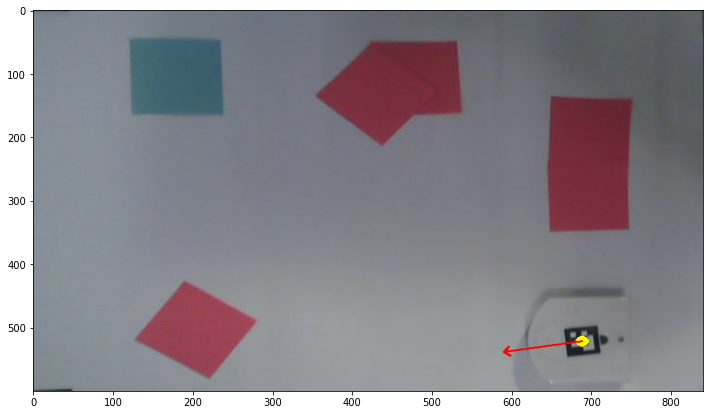

In [8]:
# Our VisionPipeline class takes care of high level tasks such as determening robot pose
pipeline = vision.VisionPipeline(source, tools)
pose = pipeline.get_robot_pose()
result = draw.draw_robot_pose(calibrated, pose)
draw.plot_image(result)

<center> Figure 5 : Direction of the robot, determined by the orientation of the marker</center>
<center> <i> x and y are in pixel </i> </center>

### 3.1.4 Goal position estimation

The goal is marked by a blue piece of paper.
To get its position we have to filter the blue pixels, detect the corresponding area, and take its center position.
To filter colors we use HSV (hue, saturation, value) color space, where hue models the color type and therefore makes filtering colors much easier.
We use OpenCV's `cv2.cvtColor()` to convert our images in HSV space and `cv2.inRange()` to detect pixels that are in our chosen color range [3].

If we choose the HSV range correctly, taking into account the current lighting, we can detect the blue square:

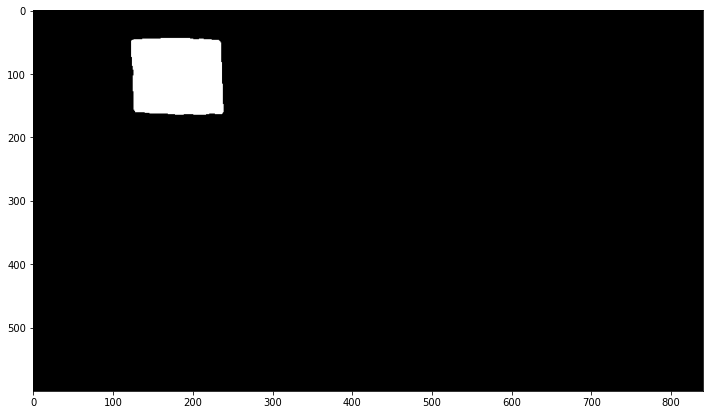

In [9]:
# Detect blue colors
mask = tools.get_color_mask(calibrated, pipeline.blue_bounds)
draw.plot_image(mask)

<center> Figure 6 : Color mask used for goal detection </center>
<center> <i> x and y are in pixel </i> </center>

Once we have the blue pixels left, we detect the contours of the blue square using OpenCV's `findContours()` [4].
We can then use image moments to obtain the centroid of the square, which corresponds to the goal position [5].

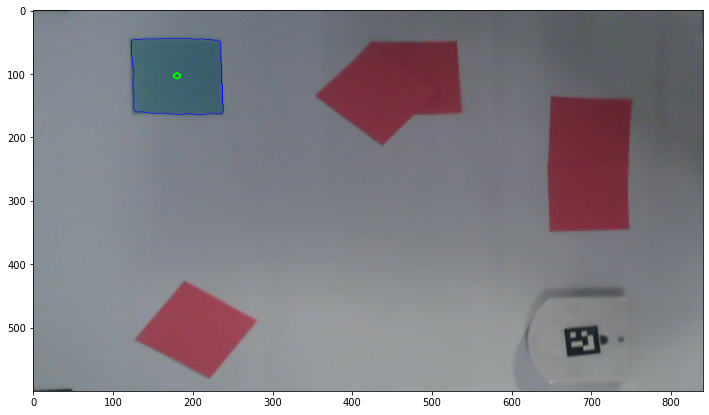

In [10]:
# Detect the contours of the blue mask
contours = tools.get_contours(mask)
# Detect the centroids of the blue mask (implicitly calls the get_contours())
centroids = tools.get_centroids(mask)
# Draw the result
result = draw.draw_contours(calibrated, contours)
result = draw.draw_centroids(result, centroids)
draw.plot_image(result)

In [7]:
<center> Figure 7 : Goal center and contour </center>
<center> <i> x and y are in pixel </i> </center>

SyntaxError: invalid syntax (836153706.py, line 1)

### 3.1.5 Detection of obstacles

The obstacles are red, we can therefore use the same HSV filtering technique with different values to get the red pixels:

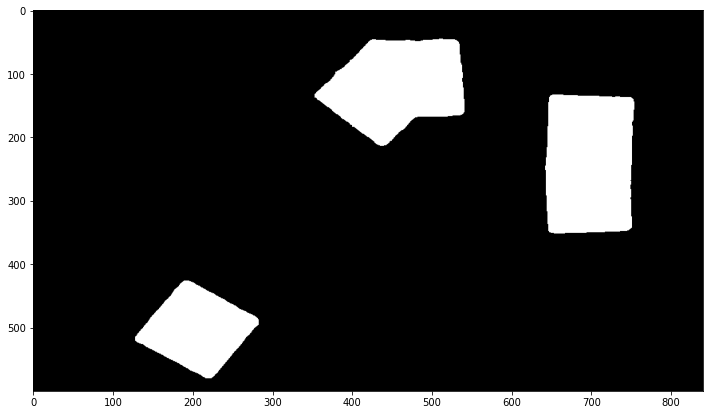

In [11]:
# Detect red colors
mask = tools.get_color_mask(calibrated, pipeline.red_bounds)
draw.plot_image(mask)

<center> Figure 8 : Color mask used for obstacle detection </center>
<center> <i> x and y are in pixel </i> </center>

We use the same contour detection technique as before to detect the contours of the red obstacles.
The problem with contours is that they are represented by many points.
If we want to create a visibility graph, which creates an edge between each set of points without intersections, this is going to create a huge amount of unnecessary edges.
This would also slow any path finding algorithm whose complexity scales with the number of edges.

Instead we use the Ramer-Douglas-Peuckler algorithm [6], implemented in OpenCV by `approxPolyDP()` [7], which approximates a curve of linear segments with a simular curve using fewer points.

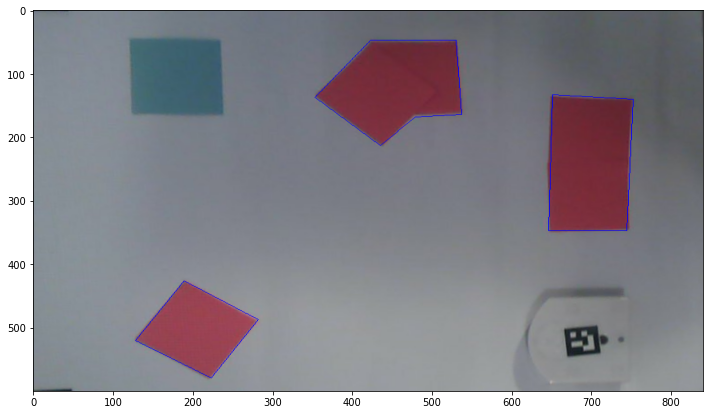

In [12]:
# Get the contours and approximate them with polygons
obstacles = tools.get_polygon_contours(mask)
result = draw.draw_contours(calibrated, obstacles)
draw.plot_image(result)

<center> Figure 9 : Contour of obstacles </center>
<center> <i> x and y are in pixel </i> </center>

If we use the obstacles as if for path planning, the robot might collide into the obstacles.
This is because the robot is represented by a point, ignoring its width.
We can compensate this by dillating the obstacles enough to take half of the robot's width into account.

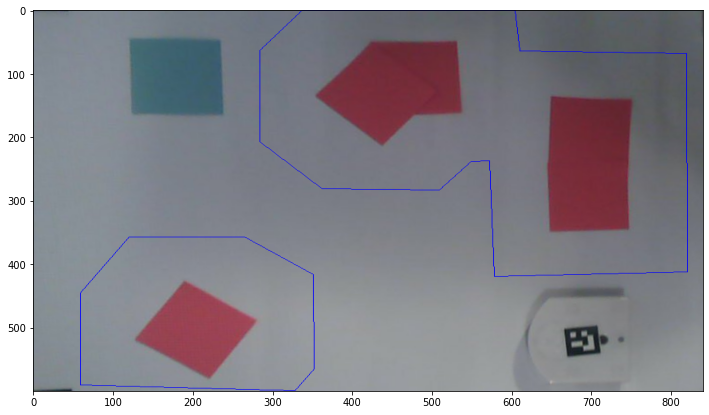

In [13]:
# Use a dilate factor to take robot width into account
obstacles = tools.get_polygon_contours(mask, dilate=140)
result = draw.draw_contours(calibrated, obstacles)
draw.plot_image(result)

<center> Figure 10 : Contour of obstacles with border </center>
<center> <i> x and y are in pixel </i> </center>

### 3.1.6 Full vision pipeline

A single call to our vision pipeline allows us to do all the above in one go and create the corresponding `World` model object:

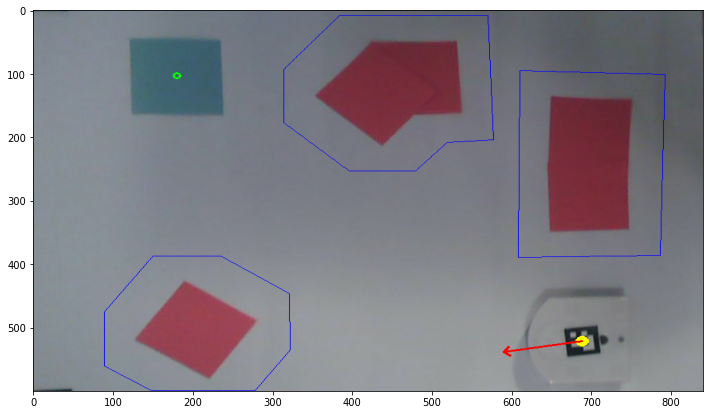

In [14]:
world = pipeline.analyze_scene()
result = draw.draw_world(calibrated, world)
draw.plot_image(result)

<center> Figure 11 : Contour of obstacles, goal point and direction of robot </center>
<center> <i> x and y are in pixel </i> </center>

### 3.2 Path planning

In [15]:
# Path planning alorithms are in src/pathfinder.py
from src import pathfinder

For this part, we decided to compute the visibility graph given the obstacles, and compute the shortest path from robot to goal using Dijkstra's shortest path algorithm.
To compute it, we used the `pyvisgraph` library [10] that allows to reduce the complexity of the algorithm from $O(n^3)$ to $O(n^2log(n))$.

### 3.2.1 Naive implementation**

The goal is to find all possible paths.
We therefore want to check if a vertice of an obstacle is visible from a previous point.

For example: the given point is the robot $R$ (first position), and we want to know what are all the visible points from that robot point. We check it as follows:
- For each point $P$:
   - For each obstacle edge $AB$:
      - If $AB$ intersects with $RP$, $P$ is not visible from $R$.

If we repeat this for every point and only keep the edges were a points are visible to each other, we obtain the visibility graph.
Running Dijkstra on this visibility graph gives us the shortest path without colliding with an obstacle.

However, we can see the complexity of this naive implementation is $O(n^3)$. 
This is not a problem for our small set of obstacles, but if we can optimise with a better algorithm it will save us resources and allow us to scale up if needed.

### 3.2.2 Lee method

The library we used, uses a method named Lee method and reduces the computation complexity to $O(n^2log(n))$.

The difference with the naive method is how visible vertices are computed.
At a point, for example the robot $R$ again, an arrow/half-line will turn counter-clockwise. When this half-line intersects a point $P$, it adds it to an array called `open_vertices` and each edge starting from this point is added to an array called `edge_detected`. 
The arrow continues to turn counter-clockwise and when it intersects again with a vertice, it adds it to `open_vertices` and also the edges in the dedicated array. But if an edge is already present, it removes it from the array. 

To know if a vertex is visible, it is in fact checking only if the half line between the robot (for our example) and the vertice on the half line intersects only with an edge in `edge_detected`. 
Because the arrow turns counter-clockwise, when you remove an edge from `edge_detected`, it means that it will be impossible for a vertex to intersect with this latter edge and hence you can avoid this test by removing it from `edge_detected`, and therefore the computation complexity will be lower. 

TODO: illustrated example here

### 3.2.3 Implementation

We simply have to convert our obstacles' list of model points into point objects of the `pyvisgraph` library.
Using this conversion we can build the graph using the library, and then compute the shortest path using `pyvisgraph`s' builtin Dijkstra's algorithm.
This allows us to have a well optimised and tested implementation.

There is however one severe limitation with the library, is the lack of support for boundaries.
Our robot acts in a limited, square environment.
The library however assumes that the robot can go anywhere, including outside of this white square.
To compensate for this, we check if any of the obstacles corners are near the border of the frame, and if so we extend them way past the border.
This way, any path that requires to go outside of the frame will be too costly, and not a solution to Dijkstra's shortest path algorithm.

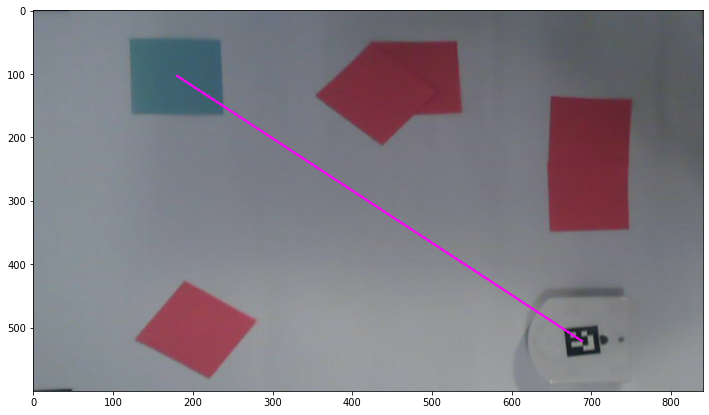

In [16]:
# We need the resolution of the frame to check for obstacles near the border
resolution = tools.target_resolution
# Compute the visibility graph and the shortest path
path = pathfinder.find_path(world, resolution)
# Draw the chosen path on the frame
result = draw.draw_path(calibrated, path)
draw.plot_image(result)

<center> Figure 12 : Path to goal </center>
<center> <i> x and y are in pixel </i> </center>

### 3.3 Global navigation

In [17]:
# Global navigation alorithms are in src/navglobal.py
from src import navglobal


### 3.4 Local navigation

In [18]:
# Local navigation alorithms are in src/navlocal.py
from src import navlocal

# Our local navigation object
avoider = navlocal.LocalNavigation()

The local navigation is based on simplified version of the bubble rebound algorithm for mobile robots [15]. 
When an obstacle is detected, that is when one of the IR sensors reads a high enough value, this algorithm determines the direction of the lowest density of obstacles and moves in this direction until no obstacle is detected. 
It then resumes global navigation.
The main advantage of this technique is it’s ease of implementation, the fact that the algorithm is very lightweight, with good results as shown in the original paper.

The main disadvantage is the need to know the current robot orientation in order to determine by how much the robot still needs to rotate. We could have kept track of the angle by tracking the motor speed of time but this information was already available to us thanks to the vision module.

The other disadvantage is that the Thymio has a very short range with its horizontal IR sensors.
This means the the obstacle is detected rather late, and if the obstacle is right in front of the Thymio, the default algorithm does not have enough time to avoid to obstacle.
We therefore modified the algorithm to either turn if the obstacle is too close, or go straight if it's next to the obstacle.
It also continues to be in local navigation mode 4 seconds after it does not detect the obstacle anymore, to make sure the robot is past it.

Our particular code implementation was modeled on a lua plugin for robotic simulation by Luyuan Wang [16].

The algorithm is described by the following activity diagram:

![bubble_rebound](../img/local_nav_activity_diagram.png)
<center>Figure 13. Activity diagram of the local navigation algorithm</center>

The key parameters for local navigation are : 
- Threshold used while pooling the IR Sensors for their value and compared to determine when local navigation should be engaged.
- Linear speed of the robot during local navigation.
- Turn speed of the robot during local navigation.
- Angle between each IR sensor. This is determined by the hardware and was calculated to be 16°

The three first parameters are to be determined together. For example, a smaller threshold means the robot will detect obstacles later and the linear speed will need to be reduced and the turn speed augmented in order to give the robot the time necessary in order to avoid the obstacle.

To detect whether there is an obstacle, we can just check whether one of the horizontal IR sensors is above the given threshold:

In [19]:
print(f'Local navigation IR threshold is: {avoider.ir_sensor_threshold}')
# Create sensor data IR sensor data under threshold
sensor_data = model.SensorReading(
    horizontal=model.HorizontalSensor(np.array([0,1000,0,0,1000])), 
    ground=model.GroundSensor([0, 0]), 
    motor=model.MotorSpeed(left=0, right=0)
)
active = avoider.sees_obstacle(sensor_data)
print(f'Sees obstacle (under threshold): {active}')

# Create sensor data with IR sensor data above threshold
sensor_data = model.SensorReading(
    horizontal=model.HorizontalSensor(np.array([0,0,0,1100,1200])), 
    ground=model.GroundSensor([0, 0]), 
    motor=model.MotorSpeed(left=0, right=0)
)
active = avoider.sees_obstacle(sensor_data)
print(f'Sees obstacle (above threshold): {active}')

Local navigation IR threshold is: 1100
Sees obstacle (under threshold): False
Sees obstacle (above threshold): True


As mentioned above, the local avoidance has to stay 4 seconds after the detection of an obstacle in local avoidance mode to make sure to be past the obstacle.
Therefore the `avoidance_mode()` function should be used.

In [20]:
print(f'Timeout threshold: {avoider.timeout} seconds')

# 1. Detects obstacle
sensor_data = model.SensorReading(
    horizontal=model.HorizontalSensor(np.array([0,0,0,1100,1200])), 
    ground=model.GroundSensor([0, 0]), 
    motor=model.MotorSpeed(left=0, right=0)
)
active = avoider.sees_obstacle(sensor_data)
avoidance = avoider.avoidance_mode(sensor_data)
print(f'Sees obstacle (above threshold) : {active}')
print(f'Avoidance mode (above threshold): {avoidance}')
print(f'---')

# 2. Does not detect obstacle anymore
sensor_data = model.SensorReading(
    horizontal=model.HorizontalSensor(np.array([0,0,0,0,0])), 
    ground=model.GroundSensor([0, 0]), 
    motor=model.MotorSpeed(left=0, right=0)
)
active = avoider.sees_obstacle(sensor_data)
avoidance = avoider.avoidance_mode(sensor_data)
print(f'Sees obstacle (below threshold) : {active}')
print(f'Avoidance mode (below threshold): {avoidance}')
print(f'---')

# 3. 2 seconds have past
time.sleep(avoider.timeout)
active = avoider.sees_obstacle(sensor_data)
avoidance = avoider.avoidance_mode(sensor_data)
print(f'Sees obstacle ({avoider.timeout} seconds) : {active}')
print(f'Avoidance mode ({avoider.timeout} seconds): {avoidance}')

Timeout threshold: 4 seconds
Sees obstacle (above threshold) : True
Avoidance mode (above threshold): True
---
Sees obstacle (below threshold) : False
Avoidance mode (below threshold): True
---
Sees obstacle (4 seconds) : False
Avoidance mode (4 seconds): False


#### Example of angle calculation

<div>
<img src="../img/angle_8.jpg" width="200"/>
    <center><figcaption>Figure 14: An obstacle at an 8 degree angle </figcaption></center>
<img src="../img/angle_-25.jpg" width="200"/>
    <center><figcaption>Figure 15 : An obstacle at an -25 degree angle </figcaption></center>
</div>


| IR 1 | IR 2 | IR 3 | IR 4 | IR 5 | Angle |
|------|------|------|------|------|-------|
| 0    | 0    | 3836 | 0    | 0    | 0°    |
| 0    | 0    | 0    | 0    | 3369 | 32°  |
| 3338 | 2719 | 0    | 0    | 0    | -25°  |
| 0    | 0    | 2779 | 3329 | 0    | 8.7°    |
<center>Table of example of value read and the calculated angle</center>

In [2]:
alpha = 80/5 #16° between each IR sensors
ir_arr = [0, 0, 2779, 3329, 9] #Example of values read by the sensor
coef_array = [-2*alpha, -1*alpha, 0, 1*alpha, 2*alpha]
sum_ir = 0
sum_coeff = 0
for i in range(5):
    sum_ir = sum_ir + ir_arr[i]
    sum_coeff = sum_coeff + coef_array[i] * ir_arr[i]
print("Angle is : "+str(sum_coeff/sum_ir))

Angle is : 8.754618276933137


### 3.5 Filtering

In [22]:
# Filtering alorithms are in src/filtering.py
from src import filtering

### 3.5.1 states and dynamics of the system
A Kalman filter is implemented to estimate the position of the robot. The system of the robot is non-linear so a non-linear Kalman filter has to be used. The states and inputs of the system that were considered are shown below.
\begin{equation}
x=
\begin{pmatrix}
x\\
y\\
\theta\\
v\\
\omega
\end{pmatrix}
u=
\begin{pmatrix}
\Delta u_l\\
\Delta u_r
\end{pmatrix}
\end{equation}
x=(x,y,theta,v,omega)
u=(delta u_l,delta u_r)
$x=[x,y,\theta,v,\omega]$
$u=[\delta u_l,\delta u_r]$

Where x and y are the coordinates of the robot, theta is the angle of the robot, v is the forward velocity, omega is the angular velocity, and delta u_l/delta u_r are the difference of the current wheel input from the previous input.

Since the system is non-linear, the equation Ax+B cannot be used to model the dynamics. Instead a set of 5 equations is used to model the dynamics of the system

\begin{equation}
\begin{pmatrix}
x_{i+1}\\
y_{i+1}\\
\theta_{i+1}\\
v_{i+1}\\
\omega_{i+1}
\end{pmatrix}
=
\begin{pmatrix}
x_i+v_i*cos(\theta)*\Delta t\\
y_i+v_i*sin(\theta)*\Delta t\\
\theta_i +\omega_i *\Delta t\\
v_i+\frac{\Delta u_l+\Delta u_r}{2}\\
\omega_i+\frac{\Delta u_r-\Delta u_l}{L}
\end{pmatrix}
\end{equation}

Where L is the full length of the thymio, and dt is the time step

### 3.5.2 Measurements
From the robot and camera, there are 2 types of measurements that can be obtained to measure the states. The position and angle can be obtained from the camera, and the speed and angular speed can be calculated from the measured speed of the wheels. The speed of the wheels can be obtained all the time but the camera cannot, for example when the camera is blocked. So, there are 2 situations of measurements:
camera data is present, so position and angle is included in the measurement
There is no camera data, so only velocity is measured
Thus, there are 2 possible C matrices (measurement y=Cx):
\begin{equation}
C_{camera}=
\begin{pmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1\\
\end{pmatrix}
C_{speed}=
\begin{pmatrix}
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1\\
\end{pmatrix}
\end{equation}

### 3.5.3 Parameter tuning
Then, the covariance matrix of the measurement(R) and states(Q) needs to be tuned. It is assumed that the variances of each state and measurement are uncorrelated and thus the covariance are diagonal matrices which contains the variance of each state/measurement in the diagonals. These are calibrated by using the camera position and by looking at the variance of the measurements. The resulting covariance matrices are shown below.
\begin{equation}
Q=
\begin{pmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & \frac{1}{L} & 0 & 0\\
0 & 0 & 0 & 6.15 & 0\\
0 & 0 & 0 & 0 & \frac{6.15}{L}
\end{pmatrix}
R=
\begin{pmatrix}
3 & 0 & 0 & 0 & 0\\
0 & 3 & 0 & 0 & 0\\
0 & 0 & \frac{3}{L} & 0 & 0\\
0 & 0 & 0 & 6.15 & 0\\
0 & 0 & 0 & 0 & \frac{6.15}{L}
\end{pmatrix}
\end{equation}
An initial variance of the state is also required. Since the initial position is found using the camera, and is a position set by the team, the initial variance of the states is assumed to be 0. So the initial variance will be a 5x5 matrix of zeros

### 3.5.4 Kalman filter
Now that the dynamics of the states and measurement are modeled, a standard nonlinear Kalman filter can now be applied. First, the Jacobian of the dynamics of the system is computed. The result is shown below.

\begin{equation}
G=
\begin{pmatrix}
1 & 0 & -\Delta t * sin(\theta) * v & cos(\theta) * d & 0\\
0 & 1 & \Delta t * cos(\theta) * v & sin(\theta) * \Delta t & 0\\
0 & 0 & 1 & 0 & \Delta t / L\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{pmatrix}

\end{equation}

\begin{equation}
\bar{\mu_{t}}=g(\mu_{t-1},u_t)
\end{equation}
With this data, the Kalman filter can then be computed. First, the predicted state of the robot is first computed using the state dynamics equations based on the previous state and current input..
\begin{equation}
\bar{\Sigma}=G\Sigma_{t-1}G^T+R
\end{equation}
Then, the predicted variance is calculated where G is the jacobiean of the dynamics.
\begin{equation}
K_t=\bar{\Sigma}H^T(H\bar{\Sigma}H^T+Q)^{-1}
\end{equation}
Using the predicted variance, the optimal gain for the Kalman filter can be calculated. H is the jacobian of the output matrix but in this case, the output matrix is linear so H=C.
\begin{equation}
\mu_{t}=\bar{\mu_{t}}+K_t(y-C\bar{\mu_{t}})
\end{equation}

\begin{equation}
\Sigma=(I-K_tH)\bar{\Sigma}
\end{equation}

Finally, the estimated state and variance can be calculated, where mu_t and Sigma_t is the estimated state and variance. The estimated state is the predicted state plus the difference between the measurement and output multiplied by the gain found above. This corrects the predicted state based on the measurement that is obtained. The estimated variance is also a correction of the predicted state based on the measurements obtained.

### 3.5.5 Example

To simulate a 

## 4. Integrating everything together

In [23]:
# TODO vision setup

In [ ]:
# Connect with the Thymio
th = thymio.Thymio()
# Setup global and local navigation object
navigator = navglobal.GlobalNavigation(path)
avoider = navlocal.LocalNavigation()
# Flag to check if we were in local avoidance
# This is used to recompute the path and update global navigation
was_in_avoidance = False
# Create the filter with initial state
kalman = filtering.Filter(world.robot)

# While we have not reached the goal
while not world.robot_at_goal(60):
    # Read data from the sensors
    sensor_data = th.read_sensor_data()

    # Check whether to use local or global navigation
    if avoider.avoidance_mode(sensor_data):
        command = avoider.next_command(sensor_data)
        was_in_avoidance = True
    else:
        # Recompute path if we left local avoidance
        if was_in_avoidance:
            path = pathfinder.find_path(world, tools.target_resolution)
            navigator = navglobal.GlobalNavigation(path)
            was_in_avoidance = False
        command = navigator.next_command(world.robot)
    # Send the command to the Thymio
    th.process_command(command)
    # Read the pose from the camera
    pose = pipeline.get_robot_pose()
    # Update state with the filter
    world.robot = kalman.update_robot(pipeline.last_robot_pose, command, sensor_data, camera=pose is not None)
# Disconnect the Thymio
th.stop()

## 5. Conclusion

This project allowed us to better understand the basics of mobile robotics. How the different modules are implemented and how they should work together in order to have a running system.  
We managed to complete the assignment in time and have a functioning system that respects the mandatory requirements. The teamwork was an important part of the job, as some modules could not be fully tested without making sure other modules were in working order.
We are satisfied with the result as it’s reliable. Our implementation tried to stay as simple as possible and with more time we would have been interested in adding more advanced features.


## References

[1] “Detection of ARUCO Markers.” OpenCV, Available at: https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html. (Accessed: December 10, 2022). 

[2] "Geometric image transformations." OpenCV. Available at: https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html (Accessed: December 10, 2022). 

[3] "Thresholding Operations using inRange." OpenCV, Available at: https://docs.opencv.org/3.4/da/d97/tutorial_threshold_inRange.html (Accessed: December 10, 2022). 

[4]  "Contours : Getting Started." OpenCV, Available at: https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html (Accessed: December 10, 2022). 

[5] Hu, M. K. (1962). Visual pattern recognition by moment invariants. IRE transactions on information theory, 8(2), 179-187.

[6] Ramer, U. (1972). An iterative procedure for the polygonal approximation of plane curves. Computer graphics and image processing, 1(3), 244-256.

[7] "Structural Analysis and Shape Descriptors." OpenCV, Available at: https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html (Accessed: December 10, 2022). 

[10] "Pyvisgraph - Python Visibility Graph." Github, Available at: https://github.com/TaipanRex/pyvisgraph (Accessed: December 10, 2022).

[15] I. Susnea, A. Filipescu, G. Vasiliu, G. Coman and A. Radaschin, "The bubble rebound obstacle avoidance algorithm for mobile robots," IEEE ICCA 2010, 2010, pp. 540-545, doi: 10.1109/ICCA.2010.5524302.

[16] "Simple Bubble-Rebound." Github, Available at: https://github.com/BeBeBerr/bubble-rebound (Accessed: October 29, 2022).